# Estimate by modelization the evolution of Unemployment Rate in USA

## Import

In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
import requests

# FINANCE
import yfinance as yf
import ccxt
from openbb_terminal.sdk import openbb

# CHARTS
import ta
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme(context='paper', style='whitegrid')

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

## Definitions

In [2]:

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
API_GLASSNODE_KEY = os.getenv("API_GLASSNODE_KEY")
openbb.keys.glassnode(key=os.getenv("API_GLASSNODE_KEY"))
openbb.keys.messari(key=os.getenv("API_MESSARI_KEY"))

# unemployment
path_unemployment = "data/UNRATE.csv"
# federal funds rate
path_rate = "data/FEDFUNDS.csv"
# inflation
path_inflation = "data/CPIAUCSL.csv"


## Load data

- unemployment data :  https://www.bls.gov/charts/employment-situation/civilian-unemployment-rate.htm# 
    - less data :  https://fred.stlouisfed.org/series/UNRATE
- Interest rate :  https://fred.stlouisfed.org/series/FEDFUNDS
- INFLATION : https://www.usinflationcalculator.com/inflation/current-inflation-rates/
   - calculated from CPI : https://fred.stlouisfed.org/series/CPIAUCSL  
   Inflation = 100 * [ CPI(month, year) - CPI(month, year-1) ] / CPI(month, year-1)
- SPX SP500 : Yahoo Finance Ticker ^GSPC but history limited to 1985
  - So Use date copy paste table from  https://www.multpl.com/s-p-500-historical-prices/table/by-month if no update needed


In [3]:
# load local data
# load unemployment
df_unemployment = pd.read_csv(path_unemployment)
df_unemployment["DATE"] = pd.to_datetime(df_unemployment["DATE"])
df_unemployment.rename(columns={"UNRATE": "Total"}, inplace=True)
# load federal funds rate
df_rate = pd.read_csv(path_rate)
df_rate["DATE"] = pd.to_datetime(df_rate["DATE"])
# load inflation
df_inflation = pd.read_csv(path_inflation)
df_inflation["DATE"] = pd.to_datetime(df_inflation["DATE"])

In [4]:

df_unemployment

,DATE,Total
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
915,2024-04-01,3.9
916,2024-05-01,4.0
917,2024-06-01,4.1
918,2024-07-01,4.3


In [5]:
# check unemployment nan into df_unemployment 
# assert that nothing is nan
assert df_unemployment.isna().sum().sum() == 0

In [6]:
100 * (314.540 - 305.691) / 305.691

2.894753198491302

In [7]:
100*(190.9 - 185.0) / 185.0

3.189189189189192

In [8]:
# calculatate inflation
df_inflation["CPI-12"]= df_inflation["CPIAUCSL"].shift(12)
df_inflation["Inflation"] = 100 * (df_inflation["CPIAUCSL"] - df_inflation["CPI-12"]) / df_inflation["CPI-12"]
df_inflation.tail(20)

,DATE,CPIAUCSL,CPI-12,Inflation
911,2022-12-01,298.812,280.808,6.411498
912,2023-01-01,300.356,282.390,6.362123
913,2023-02-01,301.509,284.535,5.965523
914,2023-03-01,301.744,287.553,4.935090
915,2023-04-01,303.032,288.764,4.941059
916,2023-05-01,303.365,291.359,4.120690
917,2023-06-01,304.003,294.996,3.053262
918,2023-07-01,304.628,294.977,3.271781
919,2023-08-01,306.187,295.209,3.718721
920,2023-09-01,307.288,296.341,3.694055


In [9]:
df = df_unemployment.merge(df_inflation.filter(["DATE", "Inflation"]), on="DATE", how="left")

df.tail(12)

,DATE,Total,Inflation
908,2023-09-01,3.8,3.694055
909,2023-10-01,3.8,3.245787
910,2023-11-01,3.7,3.139482
911,2023-12-01,3.7,3.323160
912,2024-01-01,3.7,3.105981
913,2024-02-01,3.9,3.165743
914,2024-03-01,3.8,3.475131
915,2024-04-01,3.9,3.357731
916,2024-05-01,4.0,3.250210
917,2024-06-01,4.1,2.975629


In [10]:
df_rate

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
837,2024-04-01,5.33
838,2024-05-01,5.33
839,2024-06-01,5.33
840,2024-07-01,5.33


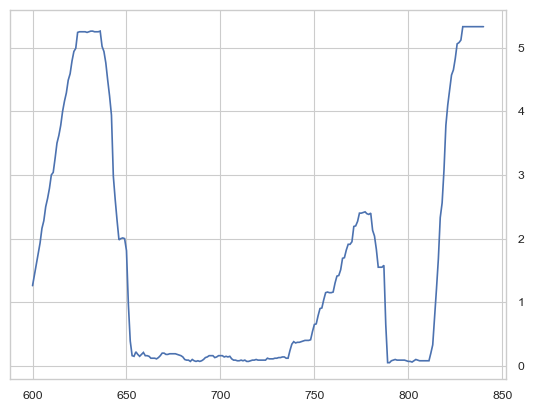

In [11]:
plt.plot(df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]["FEDFUNDS"])

In [12]:
# add funds rate to df
df = df.merge(df_rate, on="DATE", how="left")
#df["FEDFUNDS"] = df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]["FEDFUNDS"].values
df


,DATE,Total,Inflation,FEDFUNDS
0,1948-01-01,3.4,10.242086,NaN
1,1948-02-01,3.8,9.481961,NaN
2,1948-03-01,4.0,6.818182,NaN
3,1948-04-01,3.9,8.272727,NaN
4,1948-05-01,3.5,9.384966,NaN
...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33
916,2024-05-01,4.0,3.250210,5.33
917,2024-06-01,4.1,2.975629,5.33
918,2024-07-01,4.3,2.923566,5.33


In [13]:
#df.dropna(inplace=True)
df 

,DATE,Total,Inflation,FEDFUNDS
0,1948-01-01,3.4,10.242086,NaN
1,1948-02-01,3.8,9.481961,NaN
2,1948-03-01,4.0,6.818182,NaN
3,1948-04-01,3.9,8.272727,NaN
4,1948-05-01,3.5,9.384966,NaN
...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33
916,2024-05-01,4.0,3.250210,5.33
917,2024-06-01,4.1,2.975629,5.33
918,2024-07-01,4.3,2.923566,5.33


In [14]:
"""# check if nan into FEDFUNDS
assert df[df["FEDFUNDS"].isna()].shape[0] == 0
# find Nan value in inflation
assert  df[df["Inflation"].isna()].shape[0]==0"""

'# check if nan into FEDFUNDS\nassert df[df["FEDFUNDS"].isna()].shape[0] == 0\n# find Nan value in inflation\nassert  df[df["Inflation"].isna()].shape[0]==0'

In [15]:
# add do Df the indice SPX from yahoo finance ? 
# add the indice SPX from yahoo finance
date_start = df["DATE"].min().strftime("%Y-%m-%d")
date_end = df["DATE"].max().strftime("%Y-%m-%d")

updating = False
if updating:
    # check if data/SPX.csv exists and if last date is the last date of df
    if os.path.exists("data/SPX.csv"):
        df_spx = pd.read_csv("data/SPX.csv")
        last_date = df_spx["DATE"].max()
        if last_date >= date_end:
            print("SPX data is up to date")
            updating = False
        else:
            print("SPX data is not up to date")
            updating = True
    else:
        print("SPX data is not up to date")
        updating = True

    if updating:
        print("Updating...")
        df_spx = yf.Ticker("^GSPC").history(
                start=date_start, interval="1mo")
        df_spx = df_spx[["Close"]]
        df_spx["DATE"] = df_spx.index
        df_spx["DATE"] = df_spx["DATE"].dt.strftime("%Y-%m-%d")
        df_spx["DATE"] = pd.to_datetime(df_spx["DATE"])
        df_spx.to_csv("data/SPX.csv", index=False)
        print("SPX data is updated")
    else:
        df_spx["DATE"] = pd.to_datetime(df_spx["DATE"])
else:
    # read historical data
    df_spx = pd.read_csv("data/SP500_history.csv")
    # Rename the columns
    df_spx.rename(columns={"Date": "DATE", "Value": "Close"}, inplace=True)

    # Convert the date format and clean the 'Close' values by removing commas
    df_spx["DATE"] = pd.to_datetime(df_spx["DATE"], format="%b %d, %Y").dt.strftime("%Y-%m-%d")
    df_spx["DATE"] = pd.to_datetime(df_spx["DATE"])
    # sort by "DATE"
    df_spx.sort_values(by="DATE", inplace=True)
    df_spx["Close"] = df_spx["Close"].str.replace(",", "").astype(float)

# Display 
df_spx

,DATE,Close
1844,1871-01-01,4.44
1843,1871-02-01,4.50
1842,1871-03-01,4.61
1841,1871-04-01,4.74
1840,1871-05-01,4.86
...,...,...
4,2024-05-01,5235.22
3,2024-06-01,5415.14
2,2024-07-01,5538.00
1,2024-08-01,5478.21


In [16]:
df_tmp = df_spx.copy()
df_tmp["Close-12"] = df_tmp["Close"].shift(12)
df_tmp["SPX_diff"] = (df_tmp["Close"] - df_tmp["Close-12"]) / df_tmp["Close-12"]
df_spx = df_tmp
df_spx

,DATE,Close,Close-12,SPX_diff
1844,1871-01-01,4.44,NaN,NaN
1843,1871-02-01,4.50,NaN,NaN
1842,1871-03-01,4.61,NaN,NaN
1841,1871-04-01,4.74,NaN,NaN
1840,1871-05-01,4.86,NaN,NaN
...,...,...,...,...
4,2024-05-01,5235.22,4146.17,0.262664
3,2024-06-01,5415.14,4345.37,0.246186
2,2024-07-01,5538.00,4508.08,0.228461
1,2024-08-01,5478.21,4426.24,0.237667


In [17]:
df_spx.dropna()

,DATE,Close,Close-12,SPX_diff
1832,1872-01-01,4.86,4.44,0.094595
1831,1872-02-01,4.88,4.50,0.084444
1830,1872-03-01,5.04,4.61,0.093275
1829,1872-04-01,5.18,4.74,0.092827
1828,1872-05-01,5.18,4.86,0.065844
...,...,...,...,...
4,2024-05-01,5235.22,4146.17,0.262664
3,2024-06-01,5415.14,4345.37,0.246186
2,2024-07-01,5538.00,4508.08,0.228461
1,2024-08-01,5478.21,4426.24,0.237667


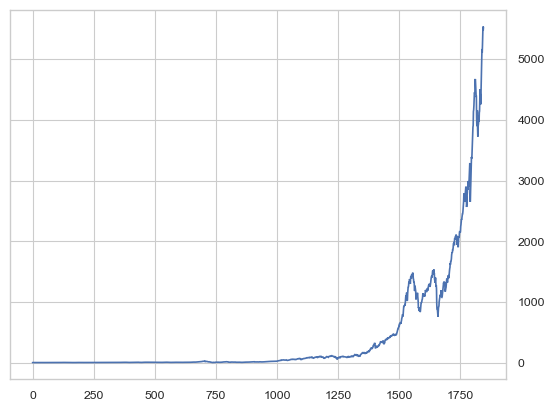

In [18]:
plt.plot(df_spx["Close"].values)

In [19]:
df = df.merge(df_spx.filter(["DATE","SPX_diff"]), how="left", on="DATE")
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff
0,1948-01-01,3.4,10.242086,NaN,-0.024984
1,1948-02-01,3.8,9.481961,NaN,-0.107595
2,1948-03-01,4.0,6.818182,NaN,-0.056728
3,1948-04-01,3.9,8.272727,NaN,0.054795
4,1948-05-01,3.5,9.384966,NaN,0.126220
...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.240453
916,2024-05-01,4.0,3.250210,5.33,0.262664
917,2024-06-01,4.1,2.975629,5.33,0.246186
918,2024-07-01,4.3,2.923566,5.33,0.228461


In [20]:
df.dropna()

,DATE,Total,Inflation,FEDFUNDS,SPX_diff
78,1954-07-01,5.8,0.261292,0.80,0.240428
79,1954-08-01,6.0,0.000000,1.22,0.259943
80,1954-09-01,6.1,-0.297508,1.07,0.351526
81,1954-10-01,5.7,-0.853432,0.85,0.342511
82,1954-11-01,5.3,-0.260708,0.83,0.364898
...,...,...,...,...,...
914,2024-03-01,3.8,3.475131,5.33,0.302883
915,2024-04-01,3.9,3.357731,5.33,0.240453
916,2024-05-01,4.0,3.250210,5.33,0.262664
917,2024-06-01,4.1,2.975629,5.33,0.246186


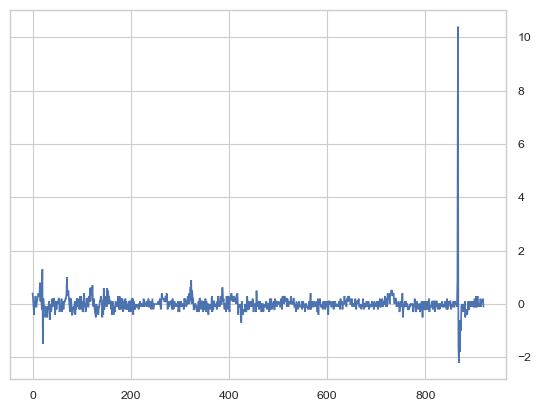

In [21]:
plt.plot(np.diff(df["Total"]))

In [22]:
# calculate next month diff in unemployment rate 
df["Total_diff"] = np.diff(df["Total"], append=np.nan)
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff
0,1948-01-01,3.4,10.242086,NaN,-0.024984,0.4
1,1948-02-01,3.8,9.481961,NaN,-0.107595,0.2
2,1948-03-01,4.0,6.818182,NaN,-0.056728,-0.1
3,1948-04-01,3.9,8.272727,NaN,0.054795,-0.4
4,1948-05-01,3.5,9.384966,NaN,0.126220,0.1
...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.240453,0.1
916,2024-05-01,4.0,3.250210,5.33,0.262664,0.1
917,2024-06-01,4.1,2.975629,5.33,0.246186,0.2
918,2024-07-01,4.3,2.923566,5.33,0.228461,-0.1


In [23]:
ur_lower = df["Total_diff"] < 0
ur_higher = df["Total_diff"] > 0
ur_stable = df["Total_diff"] == 0
# add ur to df
df["ur_lower"] = ur_lower
df["ur_higher"] = ur_higher
df["ur_stable"] = ur_stable
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable
0,1948-01-01,3.4,10.242086,NaN,-0.024984,0.4,False,True,False
1,1948-02-01,3.8,9.481961,NaN,-0.107595,0.2,False,True,False
2,1948-03-01,4.0,6.818182,NaN,-0.056728,-0.1,True,False,False
3,1948-04-01,3.9,8.272727,NaN,0.054795,-0.4,True,False,False
4,1948-05-01,3.5,9.384966,NaN,0.126220,0.1,False,True,False
...,...,...,...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.240453,0.1,False,True,False
916,2024-05-01,4.0,3.250210,5.33,0.262664,0.1,False,True,False
917,2024-06-01,4.1,2.975629,5.33,0.246186,0.2,False,True,False
918,2024-07-01,4.3,2.923566,5.33,0.228461,-0.1,True,False,False


In [24]:
# function to convert from each str input (i.e: "July 2003") to just the number of the month (i.e: 7) 
def clean_month(str_month):
    return str_month[0:3] + " " + str_month[-4:]
#clean_month("July 2003")
#df["Month"] = df["Month"].apply(clean_month)

In [25]:
# convert df["Month"] into a number of the month
#df["date"] = pd.to_datetime(df["Month"], format="%b %Y")

In [26]:
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable
0,1948-01-01,3.4,10.242086,NaN,-0.024984,0.4,False,True,False
1,1948-02-01,3.8,9.481961,NaN,-0.107595,0.2,False,True,False
2,1948-03-01,4.0,6.818182,NaN,-0.056728,-0.1,True,False,False
3,1948-04-01,3.9,8.272727,NaN,0.054795,-0.4,True,False,False
4,1948-05-01,3.5,9.384966,NaN,0.126220,0.1,False,True,False
...,...,...,...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.240453,0.1,False,True,False
916,2024-05-01,4.0,3.250210,5.33,0.262664,0.1,False,True,False
917,2024-06-01,4.1,2.975629,5.33,0.246186,0.2,False,True,False
918,2024-07-01,4.3,2.923566,5.33,0.228461,-0.1,True,False,False


In [27]:
df["num_month"] = df["DATE"].dt.month

In [28]:
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month
0,1948-01-01,3.4,10.242086,NaN,-0.024984,0.4,False,True,False,1
1,1948-02-01,3.8,9.481961,NaN,-0.107595,0.2,False,True,False,2
2,1948-03-01,4.0,6.818182,NaN,-0.056728,-0.1,True,False,False,3
3,1948-04-01,3.9,8.272727,NaN,0.054795,-0.4,True,False,False,4
4,1948-05-01,3.5,9.384966,NaN,0.126220,0.1,False,True,False,5
...,...,...,...,...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.240453,0.1,False,True,False,4
916,2024-05-01,4.0,3.250210,5.33,0.262664,0.1,False,True,False,5
917,2024-06-01,4.1,2.975629,5.33,0.246186,0.2,False,True,False,6
918,2024-07-01,4.3,2.923566,5.33,0.228461,-0.1,True,False,False,7


In [29]:
# add last 3 month data about unemployment rate, inflation , fedfunds, SPX to df 
# as new columns (i.e: "Total-1", "Total-2", "Total-3")

df["Total-1"] = df["Total"].shift(1)
df["Total-2"] = df["Total"].shift(2)
df["Total-3"] = df["Total"].shift(3)

df["Inflation-1"] = df["Inflation"].shift(1)
df["Inflation-2"] = df["Inflation"].shift(2)
df["Inflation-3"] = df["Inflation"].shift(3)

df["fedfunds-1"] = df["FEDFUNDS"].shift(1)
df["fedfunds-2"] = df["FEDFUNDS"].shift(2)
df["fedfunds-3"] = df["FEDFUNDS"].shift(3)

df["spx-1"] = df["SPX_diff"].shift(1)
df["spx-2"] = df["SPX_diff"].shift(2)
df["spx-3"] = df["SPX_diff"].shift(3)

"""# same for "Men, 20 years and over"
df["Men-1"] = df["Men, 20 years and over"].shift(1)
df["Men-2"] = df["Men, 20 years and over"].shift(2)
df["Men-3"] = df["Men, 20 years and over"].shift(3)

#same for "Women, 20 years and over"
df["Women-1"] = df["Women, 20 years and over"].shift(1)
df["Women-2"] = df["Women, 20 years and over"].shift(2)
df["Women-3"] = df["Women, 20 years and over"].shift(3)

# same for "16 to 19 years old"	
df["16-1"] = df["16 to 19 years old"].shift(1)
df["16-2"] = df["16 to 19 years old"].shift(2)
df["16-3"] = df["16 to 19 years old"].shift(3)

# same for 	"White"	
df["White-1"] = df["White"].shift(1)
df["White-2"] = df["White"].shift(2)
df["White-3"] = df["White"].shift(3)

# same for Black
df["Black-1"] = df["Black or African American"].shift(1)
df["Black-2"] = df["Black or African American"].shift(2)
df["Black-3"] = df["Black or African American"].shift(3)

# same for Asian
df["Asian-1"] = df["Asian"].shift(1)
df["Asian-2"] = df["Asian"].shift(2)
df["Asian-3"] = df["Asian"].shift(3)

# same for Hispanic or Latino
df["Hispanic-1"] = df["Hispanic or Latino"].shift(1)
df["Hispanic-2"] = df["Hispanic or Latino"].shift(2)
df["Hispanic-3"] = df["Hispanic or Latino"].shift(3)"""

'# same for "Men, 20 years and over"\ndf["Men-1"] = df["Men, 20 years and over"].shift(1)\ndf["Men-2"] = df["Men, 20 years and over"].shift(2)\ndf["Men-3"] = df["Men, 20 years and over"].shift(3)\n\n#same for "Women, 20 years and over"\ndf["Women-1"] = df["Women, 20 years and over"].shift(1)\ndf["Women-2"] = df["Women, 20 years and over"].shift(2)\ndf["Women-3"] = df["Women, 20 years and over"].shift(3)\n\n# same for "16 to 19 years old"\t\ndf["16-1"] = df["16 to 19 years old"].shift(1)\ndf["16-2"] = df["16 to 19 years old"].shift(2)\ndf["16-3"] = df["16 to 19 years old"].shift(3)\n\n# same for \t"White"\t\ndf["White-1"] = df["White"].shift(1)\ndf["White-2"] = df["White"].shift(2)\ndf["White-3"] = df["White"].shift(3)\n\n# same for Black\ndf["Black-1"] = df["Black or African American"].shift(1)\ndf["Black-2"] = df["Black or African American"].shift(2)\ndf["Black-3"] = df["Black or African American"].shift(3)\n\n# same for Asian\ndf["Asian-1"] = df["Asian"].shift(1)\ndf["Asian-2"] = df[

In [30]:
df.dropna(inplace=True)
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month,...,Total-3,Inflation-1,Inflation-2,Inflation-3,fedfunds-1,fedfunds-2,fedfunds-3,spx-1,spx-2,spx-3
81,1954-10-01,5.7,-0.853432,0.85,0.342511,-0.4,True,False,False,10,...,5.8,-0.297508,0.000000,0.261292,1.07,1.22,0.80,0.351526,0.259943,0.240428
82,1954-11-01,5.3,-0.260708,0.83,0.364898,-0.3,True,False,False,11,...,6.0,-0.853432,-0.297508,0.000000,0.85,1.07,1.22,0.342511,0.351526,0.259943
83,1954-12-01,5.0,-0.372162,1.28,0.408377,-0.1,True,False,False,12,...,6.1,-0.260708,-0.853432,-0.297508,0.83,0.85,1.07,0.364898,0.342511,0.351526
84,1955-01-01,4.9,-0.631032,1.39,0.398272,-0.2,True,False,False,1,...,5.7,-0.372162,-0.260708,-0.853432,1.28,0.83,0.85,0.408377,0.364898,0.342511
85,1955-02-01,4.7,-0.629863,1.29,0.413912,-0.1,True,False,False,2,...,5.3,-0.631032,-0.372162,-0.260708,1.39,1.28,0.83,0.398272,0.408377,0.364898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,2024-03-01,3.8,3.475131,5.33,0.302883,0.1,False,True,False,3,...,3.7,3.165743,3.105981,3.323160,5.33,5.33,5.33,0.228518,0.213053,0.197494
915,2024-04-01,3.9,3.357731,5.33,0.240453,0.1,False,True,False,4,...,3.7,3.475131,3.165743,3.105981,5.33,5.33,5.33,0.302883,0.228518,0.213053
916,2024-05-01,4.0,3.250210,5.33,0.262664,0.1,False,True,False,5,...,3.9,3.357731,3.475131,3.165743,5.33,5.33,5.33,0.240453,0.302883,0.228518
917,2024-06-01,4.1,2.975629,5.33,0.246186,0.2,False,True,False,6,...,3.8,3.250210,3.357731,3.475131,5.33,5.33,5.33,0.262664,0.240453,0.302883


In [31]:
df.columns

Index(['DATE', 'Total', 'Inflation', 'FEDFUNDS', 'SPX_diff', 'Total_diff',
       'ur_lower', 'ur_higher', 'ur_stable', 'num_month', 'Total-1', 'Total-2',
       'Total-3', 'Inflation-1', 'Inflation-2', 'Inflation-3', 'fedfunds-1',
       'fedfunds-2', 'fedfunds-3', 'spx-1', 'spx-2', 'spx-3'],
      dtype='object')

In [32]:
list_feat = ['Total', 'Inflation', 'FEDFUNDS', 'SPX_diff', 'num_month', 'Total-1',
       'Total-2', 'Total-3', 'Inflation-1', 'Inflation-2', 'Inflation-3',
       'fedfunds-1', 'fedfunds-2', 'fedfunds-3', 'spx-1', 'spx-2', 'spx-3']

df_x = df.filter(list_feat)
df_x

,Total,Inflation,FEDFUNDS,SPX_diff,num_month,Total-1,Total-2,Total-3,Inflation-1,Inflation-2,Inflation-3,fedfunds-1,fedfunds-2,fedfunds-3,spx-1,spx-2,spx-3
81,5.7,-0.853432,0.85,0.342511,10,6.1,6.0,5.8,-0.297508,0.000000,0.261292,1.07,1.22,0.80,0.351526,0.259943,0.240428
82,5.3,-0.260708,0.83,0.364898,11,5.7,6.1,6.0,-0.853432,-0.297508,0.000000,0.85,1.07,1.22,0.342511,0.351526,0.259943
83,5.0,-0.372162,1.28,0.408377,12,5.3,5.7,6.1,-0.260708,-0.853432,-0.297508,0.83,0.85,1.07,0.364898,0.342511,0.351526
84,4.9,-0.631032,1.39,0.398272,1,5.0,5.3,5.7,-0.372162,-0.260708,-0.853432,1.28,0.83,0.85,0.408377,0.364898,0.342511
85,4.7,-0.629863,1.29,0.413912,2,4.9,5.0,5.3,-0.631032,-0.372162,-0.260708,1.39,1.28,0.83,0.398272,0.408377,0.364898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,3.8,3.475131,5.33,0.302883,3,3.9,3.7,3.7,3.165743,3.105981,3.323160,5.33,5.33,5.33,0.228518,0.213053,0.197494
915,3.9,3.357731,5.33,0.240453,4,3.8,3.9,3.7,3.475131,3.165743,3.105981,5.33,5.33,5.33,0.302883,0.228518,0.213053
916,4.0,3.250210,5.33,0.262664,5,3.9,3.8,3.9,3.357731,3.475131,3.165743,5.33,5.33,5.33,0.240453,0.302883,0.228518
917,4.1,2.975629,5.33,0.246186,6,4.0,3.9,3.8,3.250210,3.357731,3.475131,5.33,5.33,5.33,0.262664,0.240453,0.302883


In [33]:
df_y = df.filter(['Total_diff',
       'ur_lower', 'ur_higher', 'ur_stable'])
df_y

,Total_diff,ur_lower,ur_higher,ur_stable
81,-0.4,True,False,False
82,-0.3,True,False,False
83,-0.1,True,False,False
84,-0.2,True,False,False
85,-0.1,True,False,False
...,...,...,...,...
914,0.1,False,True,False
915,0.1,False,True,False
916,0.1,False,True,False
917,0.2,False,True,False


In [34]:
data = df_x.values
data

array([[ 5.7       , -0.85343228,  0.85      , ...,  0.35152557,
         0.2599426 ,  0.24042816],
       [ 5.3       , -0.26070764,  0.83      , ...,  0.34251147,
         0.35152557,  0.2599426 ],
       [ 5.        , -0.37216226,  1.28      , ...,  0.36489796,
         0.34251147,  0.35152557],
       ...,
       [ 4.        ,  3.25021014,  5.33      , ...,  0.24045304,
         0.30288316,  0.22851792],
       [ 4.1       ,  2.97562853,  5.33      , ...,  0.2626641 ,
         0.24045304,  0.30288316],
       [ 4.3       ,  2.92356579,  5.33      , ...,  0.24618617,
         0.2626641 ,  0.24045304]])

## Target

Creation of a multi-class target : df_y["class"]

In [35]:
df_y["class"] = 0*df_y["ur_lower"] +1*df_y["ur_stable"] + 2*df_y["ur_higher"] 
df_y

,Total_diff,ur_lower,ur_higher,ur_stable,class
81,-0.4,True,False,False,0
82,-0.3,True,False,False,0
83,-0.1,True,False,False,0
84,-0.2,True,False,False,0
85,-0.1,True,False,False,0
...,...,...,...,...,...
914,0.1,False,True,False,2
915,0.1,False,True,False,2
916,0.1,False,True,False,2
917,0.2,False,True,False,2


In [36]:
list_targets = ["ur_lower", "ur_stable", "ur_higher"]

In [37]:
target = df_y["ur_lower"].values
target

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False,  True, False,  True,  True, False,  True,
       False, False, False,  True,  True, False, False,  True, False,
        True,  True, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False,  True,  True,
        True, False,  True,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
        True, False,  True,  True,  True,  True,  True, False, False,
        True, False,  True, False,  True,  True, False,  True, False,
       False,  True, False, False,  True, False,  True, False, False,
       False,  True, False,  True, False,  True,  True, False,  True,
       False, False, False,  True, False,  True, False,  True, False,
        True, False,

## SPlit Train / Test

In [38]:
data.shape

(838, 17)

In [39]:
ratio_test = 0.03
nb_test = int(data.shape[0] * (1 - ratio_test))
print("nb_test : ", nb_test)
#from sklearn.model_selection import train_test_split
#xtrain, xtest, ytrain, ytest = train_test_split(data, target, train_size=0.8)
xtrain = data[:nb_test, :]
xtest = data[nb_test:, :]
ytrain = target[:nb_test]
ytest = target[nb_test:]

nb_test :  812


In [40]:
ytrain.shape

(812,)

In [41]:
ytest.shape

(26,)

In [42]:
df_train = df.iloc[:nb_test].copy()
df_train
df_test = df.iloc[nb_test:].copy()
df_test

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month,...,Total-3,Inflation-1,Inflation-2,Inflation-3,fedfunds-1,fedfunds-2,fedfunds-3,spx-1,spx-2,spx-3
893,2022-06-01,3.6,8.989744,1.21,-0.080109,-0.1,True,False,False,6,...,3.6,8.532997,8.251859,8.547431,0.77,0.33,0.20,-0.030589,0.060398,0.122940
894,2022-07-01,3.5,8.449819,1.68,-0.103577,0.1,False,True,False,7,...,3.7,8.989744,8.532997,8.251859,1.21,0.77,0.33,-0.080109,-0.030589,0.060398
895,2022-08-01,3.6,8.218806,2.33,-0.066375,-0.1,True,False,False,8,...,3.6,8.449819,8.989744,8.532997,1.68,1.21,0.77,-0.103577,-0.080109,-0.030589
896,2022-09-01,3.5,8.198272,2.56,-0.133847,0.1,False,True,False,9,...,3.6,8.218806,8.449819,8.989744,2.33,1.68,1.21,-0.066375,-0.103577,-0.080109
897,2022-10-01,3.6,7.751941,3.08,-0.164696,0.0,False,False,True,10,...,3.5,8.198272,8.218806,8.449819,2.56,2.33,1.68,-0.133847,-0.066375,-0.103577
898,2022-11-01,3.6,7.119466,3.78,-0.160668,-0.1,True,False,False,11,...,3.6,7.751941,8.198272,8.218806,3.08,2.56,2.33,-0.164696,-0.133847,-0.066375
899,2022-12-01,3.5,6.411498,4.10,-0.163086,-0.1,True,False,False,12,...,3.5,7.119466,7.751941,8.198272,3.78,3.08,2.56,-0.160668,-0.164696,-0.133847
900,2023-01-01,3.4,6.362123,4.33,-0.134059,0.2,False,True,False,1,...,3.6,6.411498,7.119466,7.751941,4.10,3.78,3.08,-0.163086,-0.160668,-0.164696
901,2023-02-01,3.6,5.965523,4.57,-0.080320,-0.1,True,False,False,2,...,3.6,6.362123,6.411498,7.119466,4.33,4.10,3.78,-0.134059,-0.163086,-0.160668
902,2023-03-01,3.5,4.935090,4.65,-0.096261,-0.1,True,False,False,3,...,3.5,5.965523,6.362123,6.411498,4.57,4.33,4.10,-0.080320,-0.134059,-0.163086


In [43]:
df_test

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month,...,Total-3,Inflation-1,Inflation-2,Inflation-3,fedfunds-1,fedfunds-2,fedfunds-3,spx-1,spx-2,spx-3
893,2022-06-01,3.6,8.989744,1.21,-0.080109,-0.1,True,False,False,6,...,3.6,8.532997,8.251859,8.547431,0.77,0.33,0.20,-0.030589,0.060398,0.122940
894,2022-07-01,3.5,8.449819,1.68,-0.103577,0.1,False,True,False,7,...,3.7,8.989744,8.532997,8.251859,1.21,0.77,0.33,-0.080109,-0.030589,0.060398
895,2022-08-01,3.6,8.218806,2.33,-0.066375,-0.1,True,False,False,8,...,3.6,8.449819,8.989744,8.532997,1.68,1.21,0.77,-0.103577,-0.080109,-0.030589
896,2022-09-01,3.5,8.198272,2.56,-0.133847,0.1,False,True,False,9,...,3.6,8.218806,8.449819,8.989744,2.33,1.68,1.21,-0.066375,-0.103577,-0.080109
897,2022-10-01,3.6,7.751941,3.08,-0.164696,0.0,False,False,True,10,...,3.5,8.198272,8.218806,8.449819,2.56,2.33,1.68,-0.133847,-0.066375,-0.103577
898,2022-11-01,3.6,7.119466,3.78,-0.160668,-0.1,True,False,False,11,...,3.6,7.751941,8.198272,8.218806,3.08,2.56,2.33,-0.164696,-0.133847,-0.066375
899,2022-12-01,3.5,6.411498,4.10,-0.163086,-0.1,True,False,False,12,...,3.5,7.119466,7.751941,8.198272,3.78,3.08,2.56,-0.160668,-0.164696,-0.133847
900,2023-01-01,3.4,6.362123,4.33,-0.134059,0.2,False,True,False,1,...,3.6,6.411498,7.119466,7.751941,4.10,3.78,3.08,-0.163086,-0.160668,-0.164696
901,2023-02-01,3.6,5.965523,4.57,-0.080320,-0.1,True,False,False,2,...,3.6,6.362123,6.411498,7.119466,4.33,4.10,3.78,-0.134059,-0.163086,-0.160668
902,2023-03-01,3.5,4.935090,4.65,-0.096261,-0.1,True,False,False,3,...,3.5,5.965523,6.362123,6.411498,4.57,4.33,4.10,-0.080320,-0.134059,-0.163086


### Check features repart

In [44]:
df_train["TRAIN"] = 1
df_test["TRAIN"] = 0
df = pd.concat([df_train, df_test], axis=0)
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month,...,Inflation-1,Inflation-2,Inflation-3,fedfunds-1,fedfunds-2,fedfunds-3,spx-1,spx-2,spx-3,TRAIN
81,1954-10-01,5.7,-0.853432,0.85,0.342511,-0.4,True,False,False,10,...,-0.297508,0.000000,0.261292,1.07,1.22,0.80,0.351526,0.259943,0.240428,1
82,1954-11-01,5.3,-0.260708,0.83,0.364898,-0.3,True,False,False,11,...,-0.853432,-0.297508,0.000000,0.85,1.07,1.22,0.342511,0.351526,0.259943,1
83,1954-12-01,5.0,-0.372162,1.28,0.408377,-0.1,True,False,False,12,...,-0.260708,-0.853432,-0.297508,0.83,0.85,1.07,0.364898,0.342511,0.351526,1
84,1955-01-01,4.9,-0.631032,1.39,0.398272,-0.2,True,False,False,1,...,-0.372162,-0.260708,-0.853432,1.28,0.83,0.85,0.408377,0.364898,0.342511,1
85,1955-02-01,4.7,-0.629863,1.29,0.413912,-0.1,True,False,False,2,...,-0.631032,-0.372162,-0.260708,1.39,1.28,0.83,0.398272,0.408377,0.364898,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,2024-03-01,3.8,3.475131,5.33,0.302883,0.1,False,True,False,3,...,3.165743,3.105981,3.323160,5.33,5.33,5.33,0.228518,0.213053,0.197494,0
915,2024-04-01,3.9,3.357731,5.33,0.240453,0.1,False,True,False,4,...,3.475131,3.165743,3.105981,5.33,5.33,5.33,0.302883,0.228518,0.213053,0
916,2024-05-01,4.0,3.250210,5.33,0.262664,0.1,False,True,False,5,...,3.357731,3.475131,3.165743,5.33,5.33,5.33,0.240453,0.302883,0.228518,0
917,2024-06-01,4.1,2.975629,5.33,0.246186,0.2,False,True,False,6,...,3.250210,3.357731,3.475131,5.33,5.33,5.33,0.262664,0.240453,0.302883,0


#### Check Out of range
check if Test out of Train range for each features

In [45]:
df_min = df.filter(list_feat).groupby(df["TRAIN"]).min().transpose()
df_min["feat"] = df_min.index
df_min["out_min"] = df_min[0] < df_min[1]
df_min["pc_out_min"] = df_min["feat"].apply(
    lambda x: 100*sum(df[df["TRAIN"] == 0 ][x] <  df[df["TRAIN"] == 1][x].min()) / df[df["TRAIN"] == 0 ].shape[0]
    )
df_min

TRAIN,0,1,feat,out_min,pc_out_min
Total,3.400000,3.400000,Total,False,0.0
Inflation,2.923566,-1.958761,Inflation,False,0.0
FEDFUNDS,1.210000,0.050000,FEDFUNDS,False,0.0
SPX_diff,-0.164696,-0.425084,SPX_diff,False,0.0
num_month,1.000000,1.000000,num_month,False,0.0
Total-1,3.400000,3.400000,Total-1,False,0.0
Total-2,3.400000,3.400000,Total-2,False,0.0
Total-3,3.400000,3.400000,Total-3,False,0.0
Inflation-1,2.975629,-1.958761,Inflation-1,False,0.0
Inflation-2,3.053262,-1.958761,Inflation-2,False,0.0


In [46]:
df_max = df.filter(list_feat).groupby(df["TRAIN"]).max().transpose()
df_max["feat"] = df_max.index
df_max["out_max"] = df_max[0] > df_max[1]
df_max["pc_out_max"] = df_max["feat"].apply(
    lambda x: 100*sum(df[df["TRAIN"] == 0 ][x] >  df[df["TRAIN"] == 1][x].max()) / df[df["TRAIN"] == 0 ].shape[0]
    )
df_max

TRAIN,0,1,feat,out_max,pc_out_max
Total,4.300000,14.800000,Total,False,0.0
Inflation,8.989744,14.592275,Inflation,False,0.0
FEDFUNDS,5.330000,19.100000,FEDFUNDS,False,0.0
SPX_diff,0.302883,0.526508,SPX_diff,False,0.0
num_month,12.000000,12.000000,num_month,False,0.0
Total-1,4.100000,14.800000,Total-1,False,0.0
Total-2,4.000000,14.800000,Total-2,False,0.0
Total-3,3.900000,14.800000,Total-3,False,0.0
Inflation-1,8.989744,14.592275,Inflation-1,False,0.0
Inflation-2,8.989744,14.592275,Inflation-2,False,0.0


In [47]:
df_min.at["Total", 1]

3.4

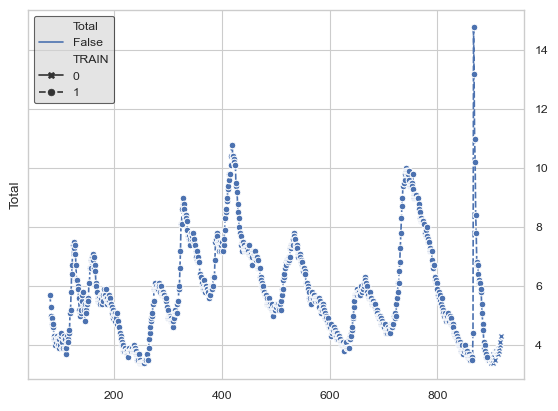

In [48]:
# detect unemployment rate < in test set
markers = {0: "X", 1: "o"}
ax = sns.lineplot(df.index.values, 
                df["Total"], hue=df["Total"] > df_max.at["Total", 1] , 
                style=df["TRAIN"], 
                markers=markers)
sns.move_legend(ax, "best", facecolor="lightgrey")

[Text(0.0, 1.0, 'Detect Inflation test > max TRAIN set')]

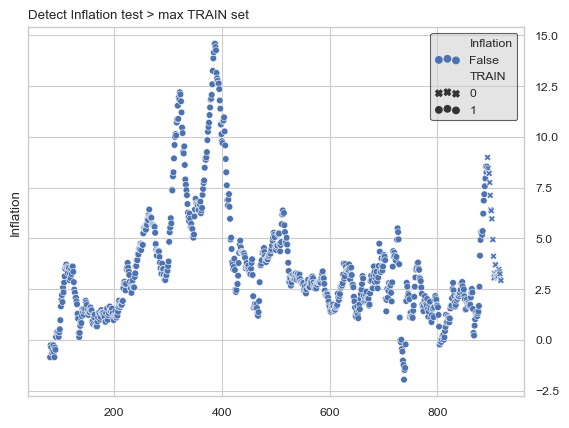

In [49]:
# detect FEDFUNDS > in test set

markers = {0: "X", 1: "o"}
ax = sns.scatterplot(df.index.values, 
                df["Inflation"], 
                hue=df["Inflation"] > df_max.at["Inflation", 1], 
                style=df["TRAIN"], 
                markers=markers)
sns.move_legend(ax, "best", facecolor="lightgrey")
ax.set(title="Detect Inflation test > max TRAIN set")

[Text(0.0, 1.0, 'Detect FEDFUNDS test > max TRAIN set')]

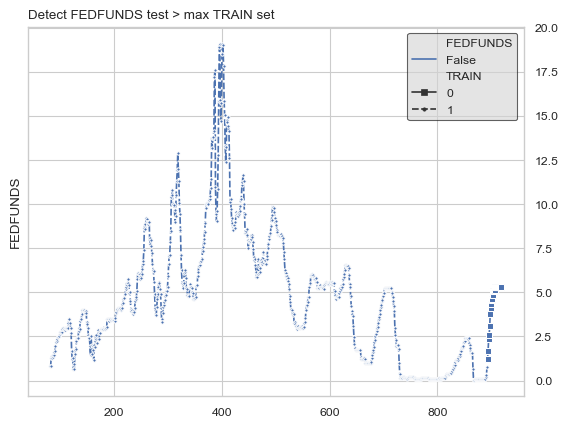

In [50]:
# detect FEDFUNDS > in test set

markers = {0: "s", 1: "."}
ax = sns.lineplot(df.index.values, 
                df["FEDFUNDS"], 
                hue=df["FEDFUNDS"] < df_min.at["FEDFUNDS", 1], 
                style=df["TRAIN"], 
                markers=markers,
                )
sns.move_legend(ax, "best", facecolor="lightgrey")
ax.set(title="Detect FEDFUNDS test > max TRAIN set")

### Check repart target

In [51]:
def print_repart(df_train, df_test, str_target):
    print("\nRepart for ", str_target, ":")
    print("- on TRAIN :\n",
        "  - proba:\n",
        df_train[str_target].value_counts() / df_train.shape[0],
        "\n  - nb: ", 
        df_train[str_target].shape[0]*(df_train[str_target].value_counts() / df_train.shape[0]).values,
    )
    print("- on TEST :\n", 
        "  - proba:\n",
        df_test[str_target].value_counts() / df_test.shape[0],
        "\n  - nb: ", 
        df_test[str_target].shape[0]*(df_test[str_target].value_counts() / df_test.shape[0]).values,)

for str_target in list_targets:
    print_repart(df_train, df_test, str_target)

print("end")


Repart for  ur_lower :
- on TRAIN :
   - proba:
 False    0.584975
True     0.415025
Name: ur_lower, dtype: float64 
  - nb:  [475. 337.]
- on TEST :
   - proba:
 False    0.576923
True     0.423077
Name: ur_lower, dtype: float64 
  - nb:  [15. 11.]

Repart for  ur_stable :
- on TRAIN :
   - proba:
 False    0.747537
True     0.252463
Name: ur_stable, dtype: float64 
  - nb:  [607. 205.]
- on TEST :
   - proba:
 False    0.807692
True     0.192308
Name: ur_stable, dtype: float64 
  - nb:  [21.  5.]

Repart for  ur_higher :
- on TRAIN :
   - proba:
 False    0.667488
True     0.332512
Name: ur_higher, dtype: float64 
  - nb:  [542. 270.]
- on TEST :
   - proba:
 False    0.615385
True     0.384615
Name: ur_higher, dtype: float64 
  - nb:  [16. 10.]
end


## Scale

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(xtrain)
X_test = scaler.transform(xtest)

# for last pred : (to predict next month value)
x_for_pred = df.filter(list_feat).iloc[-1].values.reshape(1, -1)
X_for_pred = scaler.transform(x_for_pred)
X_for_pred

array([[-0.96854595, -0.22650404,  0.19437695,  0.87120859,  0.14597715,
        -1.09263245, -1.15615168, -1.2198648 , -0.20424194, -0.10280243,
        -0.0608682 ,  0.19429529,  0.1940553 ,  0.19389644,  0.978788  ,
         1.08033351,  0.93908339]])

In [53]:
#scaler_y = StandardScaler()

#Y = scaler_y.fit_transform(ytrain.reshape(-1, 1))
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)

## Train

### Test some models

In [54]:
from sklearn.base import clone
def choose_target(df_y, target, nb_test):
    print("\nTarget : ", target)
    arr_target = df_y[target].values
    ytrain = arr_target[:nb_test]
    ytest = arr_target[nb_test:]
    Y = ytrain.reshape(-1, 1)
    Y_test = ytest.reshape(-1, 1)
    return Y, Y_test


def fit_clf(clf, X, Y, X_test, Y_test, X_for_pred):
    clf.fit(X, Y)
    print("TRAIN score :", clf.score(X, Y))
    print("TEST score :", clf.score(X_test, Y_test))
    print("Next month : ", 
      clf.predict(X_for_pred),
      np.max(clf.predict_proba(X_for_pred)[0]),
    )
    return clf
    
def multi_target_fit(clf, df_y, nb_test, list_targets):
    list_clf = []
    for target in list_targets:
        Y, Y_test = choose_target(df_y, target=target, nb_test=nb_test)
        new_clf = fit_clf(clone(clf), X, Y, X_test, Y_test, X_for_pred)
        list_clf.append(new_clf)
    return list_clf

In [55]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 0.5972906403940886
TEST score : 0.5769230769230769
Next month :  [False] 0.5401610930155866

Target :  ur_stable
TRAIN score : 0.7376847290640394
TEST score : 0.8076923076923077
Next month :  [False] 0.5770437677209102

Target :  ur_higher
TRAIN score : 0.6391625615763546
TEST score : 0.4230769230769231
Next month :  [False] 0.8542771801856839


In [56]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])


Target :  class
TRAIN score : 0.45320197044334976
TEST score : 0.3076923076923077
Next month :  [1] 0.43576541091884663


In [57]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])

"""clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))"""


Target :  class
TRAIN score : 0.5024630541871922
TEST score : 0.34615384615384615
Next month :  [0] 0.715263202727787


'clf.fit(X, Y)\nprint("TRAIN score :", clf.score(X, Y))\nprint("TEST score :", clf.score(X_test, Y_test))\nprint("Next month : ", clf.predict(X_for_pred))\nprint("classes : ", clf.classes_)\nprint("classes prob : ", clf.predict_proba(X_for_pred))'

In [58]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])


Target :  class
TRAIN score : 1.0
TEST score : 0.3076923076923077
Next month :  [2] 1.0


In [59]:
from sklearn.svm import SVC
clf = SVC(gamma='auto', probability=True)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])


Target :  class
TRAIN score : 0.5320197044334976
TEST score : 0.4230769230769231
Next month :  [0] 0.46046752223170834


In [60]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(random_state=0, loss="log_loss")
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])


Target :  class
TRAIN score : 0.3842364532019704
TEST score : 0.5
Next month :  [2] 0.7324379965899719


### KNN

In [61]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 0.7327586206896551
TEST score : 0.5384615384615384
Next month :  [False] 0.6666666666666666

Target :  ur_stable
TRAIN score : 0.8041871921182266
TEST score : 0.7692307692307693
Next month :  [ True] 0.6666666666666666

Target :  ur_higher
TRAIN score : 0.7684729064039408
TEST score : 0.5769230769230769
Next month :  [False] 1.0


Multi-class : 

In [62]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets=["class"])


Target :  class
TRAIN score : 0.6194581280788177
TEST score : 0.4230769230769231
Next month :  [1] 0.6666666666666666


### GradienBoost

one-by-one class :

In [63]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=2)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 0.8891625615763546
TEST score : 0.5769230769230769
Next month :  [False] 0.5946965806866578

Target :  ur_stable
TRAIN score : 0.8682266009852216
TEST score : 0.6538461538461539
Next month :  [False] 0.7760022657936757

Target :  ur_higher
TRAIN score : 0.875615763546798
TEST score : 0.5769230769230769
Next month :  [False] 0.6956914900983011


All classes : 

In [64]:
arr_proba_train = np.zeros((nb_test, len(list_targets)))
arr_proba_test = np.zeros((df_y.shape[0]-nb_test, len(list_targets)))
# loop over clf
for i_clf, target in enumerate(list_targets):
    clf_curr =  list_clf[i_clf]
    Y, Y_test = choose_target(df_y, target=target, nb_test=nb_test)
    arr_proba_train[:,i_clf] = clf_curr.predict_proba(X)[:, np.argmax(clf_curr.classes_ == True)]
    arr_proba_test[:,i_clf] = clf_curr.predict_proba(X_test)[:, np.argmax(clf_curr.classes_ == True)]
# final accuracy
Y_pred = np.argmax(arr_proba_train, axis=1)
Y_test_pred = np.argmax(arr_proba_test, axis=1)
Y_multi = df_y.iloc[:nb_test]["class"].values
Y_multi_test = df_y.iloc[nb_test:]["class"].values

from sklearn.metrics import accuracy_score
print("Accuracy train : ", accuracy_score(Y_multi, Y_pred))
print("Accuracy test : ", accuracy_score(Y_multi_test, Y_test_pred))


Target :  ur_lower

Target :  ur_stable

Target :  ur_higher
Accuracy train :  0.8669950738916257
Accuracy test :  0.34615384615384615


Only first and second class : ur_lower and ur_stable :  

In [65]:
list_targets_red = list_targets[:2]
print(list_targets_red)
arr_proba_train = np.zeros((nb_test, len(list_targets_red)))
arr_proba_test = np.zeros((df_y.shape[0]-nb_test, len(list_targets_red)))
# loop over clf
for i_clf, target in enumerate(list_targets_red):
    clf_curr =  list_clf[i_clf]
    Y, Y_test = choose_target(df_y, target=target, nb_test=nb_test)
    arr_proba_train[:,i_clf] = clf_curr.predict_proba(X)[:, np.argmax(clf_curr.classes_ == True)]
    arr_proba_test[:,i_clf] = clf_curr.predict_proba(X_test)[:, np.argmax(clf_curr.classes_ == True)]
# prediction , last class if other pred < 0.5
Y_pred = np.argmax(arr_proba_train, axis=1)
Y_pred[np.all(arr_proba_train < 0.5, axis=1)] = 2

Y_test_pred = np.argmax(arr_proba_test, axis=1)
Y_test_pred[np.all(arr_proba_test < 0.5, axis=1)] = 2

Y_multi = df_y.iloc[:nb_test]["class"].values
Y_multi_test = df_y.iloc[nb_test:]["class"].values
# final accuracy
from sklearn.metrics import accuracy_score
print("Accuracy train : ", accuracy_score(Y_multi, Y_pred))
print("Accuracy test : ", accuracy_score(Y_multi_test, Y_test_pred))

['ur_lower', 'ur_stable']

Target :  ur_lower

Target :  ur_stable
Accuracy train :  0.7783251231527094
Accuracy test :  0.34615384615384615


Multi-class : 

In [66]:
Y, Y_test = choose_target(df_y, target="class", nb_test=nb_test)
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))


Target :  class
TRAIN score : 0.8768472906403941
TEST score : 0.3076923076923077


In [67]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=1)
list_clf = multi_target_fit(
    clf,
    df_y,
    nb_test,
    list_targets=["class"],
)


Target :  class
TRAIN score : 0.8879310344827587
TEST score : 0.2692307692307692
Next month :  [0] 0.5266316621634072


In [68]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=2)
list_clf = multi_target_fit(
    clf,
    df_y,
    nb_test,
    list_targets=["class"],
)


Target :  class
TRAIN score : 0.8879310344827587
TEST score : 0.3076923076923077
Next month :  [0] 0.4595640993995918


### MCP

Multi-class

In [69]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0)
list_clf = multi_target_fit(
    clf,
    df_y,
    nb_test,
    list_targets=["class"],
)
print("nb iteration : ", list_clf[-1].n_iter_)


Target :  class
TRAIN score : 0.5480295566502463
TEST score : 0.3076923076923077
Next month :  [1] 0.40055718621597264
nb iteration :  200


In [70]:
clf = MLPClassifier(random_state=0, 
                    max_iter=3000,
                    n_iter_no_change=3000)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
print("nb iteration : ", list_clf[-1].n_iter_)


Target :  class
TRAIN score : 0.7992610837438424
TEST score : 0.38461538461538464
Next month :  [1] 0.40467888854935397
nb iteration :  3000


In [71]:
clf = MLPClassifier(hidden_layer_sizes=(256),
                    random_state=0, 
                    max_iter=32000,
                    n_iter_no_change=32000)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
print("nb iteration : ", list_clf[-1].n_iter_)


Target :  class
TRAIN score : 1.0
TEST score : 0.5
Next month :  [0] 0.9999999998805851
nb iteration :  32000


In [72]:
from sklearn.neural_network import MLPClassifier
list_nb_iter = [1000, 2000, 4000, 8000, 16000, 32000]
list_random_state = [0, 1, 2, 3, 4]
list_nb_cell = [4, 8, 16, 32, 64, 128, 256]
df_res = pd.DataFrame(columns=["nb_neurons", "nb_iter", "random_state", "accuracy", "accuracy_test"])
Y, Y_test = choose_target(df_y, "class", nb_test)
acc_best = 0
for nb_neurons in list_nb_cell:
    for nb_iter in list_nb_iter:
        for random_state in list_random_state:
            param = (nb_neurons, nb_iter, random_state)
            print(f"\nnb_neurons: {nb_neurons} , nb_iter: {nb_iter}, random_state: {random_state}")
            clf = MLPClassifier(
                hidden_layer_sizes=(nb_neurons),
                random_state=random_state, 
                max_iter=nb_iter,
                n_iter_no_change=nb_iter,
            )
            list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
            acc_curr = list_clf[0].score(X, Y)
            acc_curr_test = list_clf[0].score(X_test, Y_test)
            df_res = df_res.append(
                {
                    "nb_neurons": nb_neurons, 
                    "nb_iter": nb_iter, 
                    "random_state": random_state, 
                    "accuracy": acc_curr, 
                    "accuracy_test": acc_curr_test,
                }, 
                ignore_index=True,
            )

            if acc_curr_test > acc_best:
                acc_best = acc_curr_test
                param_best = param
                clf_best = list_clf[0]


print("new best param : ", param_best)
print("TRAIN score  best :", list_clf[0].score(X, Y))
print("TEST score best :", acc_best)
df_res


Target :  class

nb_neurons: 4 , nb_iter: 1000, random_state: 0

Target :  class
TRAIN score : 0.520935960591133
TEST score : 0.4230769230769231
Next month :  [0] 0.4270229163762406

nb_neurons: 4 , nb_iter: 1000, random_state: 1

Target :  class
TRAIN score : 0.49261083743842365
TEST score : 0.3076923076923077
Next month :  [0] 0.4679475719159728

nb_neurons: 4 , nb_iter: 1000, random_state: 2

Target :  class
TRAIN score : 0.5283251231527094
TEST score : 0.46153846153846156
Next month :  [2] 0.3805167016452497

nb_neurons: 4 , nb_iter: 1000, random_state: 3

Target :  class
TRAIN score : 0.5147783251231527
TEST score : 0.34615384615384615
Next month :  [0] 0.407878034166583

nb_neurons: 4 , nb_iter: 1000, random_state: 4

Target :  class
TRAIN score : 0.5135467980295566
TEST score : 0.3076923076923077
Next month :  [0] 0.4381825718623318

nb_neurons: 4 , nb_iter: 2000, random_state: 0

Target :  class
TRAIN score : 0.5270935960591133
TEST score : 0.46153846153846156
Next month :  [0

,nb_neurons,nb_iter,random_state,accuracy,accuracy_test
0,4.0,1000.0,0.0,0.520936,0.423077
1,4.0,1000.0,1.0,0.492611,0.307692
2,4.0,1000.0,2.0,0.528325,0.461538
3,4.0,1000.0,3.0,0.514778,0.346154
4,4.0,1000.0,4.0,0.513547,0.307692
...,...,...,...,...,...
205,256.0,32000.0,0.0,1.000000,0.500000
206,256.0,32000.0,1.0,1.000000,0.307692
207,256.0,32000.0,2.0,1.000000,0.423077
208,256.0,32000.0,3.0,1.000000,0.423077


In [73]:
df_res.to_csv(f"data/res_mlp_{ratio_test}.csv", index=False)

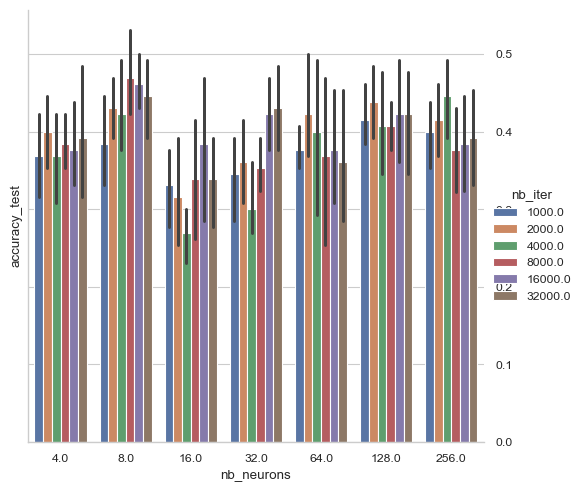

In [74]:
sns.catplot(data=df_res, kind="bar", x="nb_neurons", y="accuracy_test", hue="nb_iter")

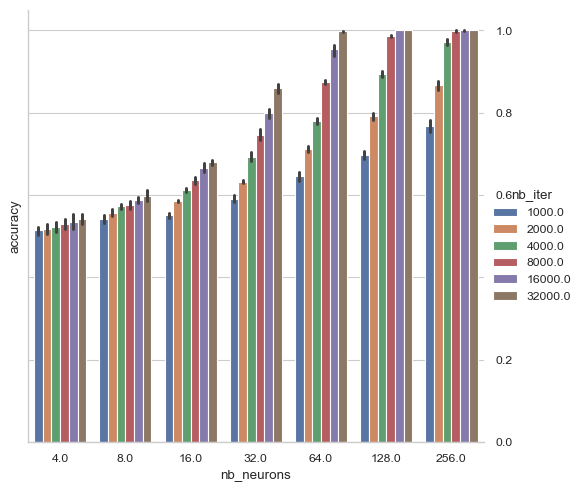

In [75]:
sns.catplot(data=df_res, kind="bar", x="nb_neurons", y="accuracy", hue="nb_iter")

In [76]:
df_res[df_res["nb_neurons"] == 256]

,nb_neurons,nb_iter,random_state,accuracy,accuracy_test
180,256.0,1000.0,0.0,0.780788,0.307692
181,256.0,1000.0,1.0,0.779557,0.384615
182,256.0,1000.0,2.0,0.762315,0.423077
183,256.0,1000.0,3.0,0.782020,0.423077
184,256.0,1000.0,4.0,0.738916,0.461538
185,256.0,2000.0,0.0,0.843596,0.423077
186,256.0,2000.0,1.0,0.871921,0.384615
187,256.0,2000.0,2.0,0.874384,0.346154
188,256.0,2000.0,3.0,0.879310,0.500000
189,256.0,2000.0,4.0,0.871921,0.423077


In [77]:
clf = MLPClassifier(
                hidden_layer_sizes=(256),
                random_state=4, 
                max_iter=1000,
                n_iter_no_change=1000,
            )
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])


Target :  class
TRAIN score : 0.7389162561576355
TEST score : 0.46153846153846156
Next month :  [0] 0.5874656108310718


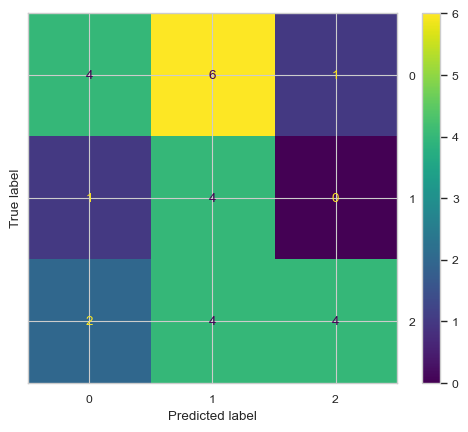

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = list_clf[0].predict(X_test)
cm = confusion_matrix(Y_test, predictions, labels=list_clf[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list_clf[0].classes_)
disp.plot()
plt.show()

In [79]:
clf = MLPClassifier(hidden_layer_sizes=(16),
                    random_state=1, 
                    max_iter=1000,
                    n_iter_no_change=1000)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
print("nb iteration : ", list_clf[-1].n_iter_)


Target :  class
TRAIN score : 0.5615763546798029
TEST score : 0.3076923076923077
Next month :  [2] 0.35939720170531564
nb iteration :  1000


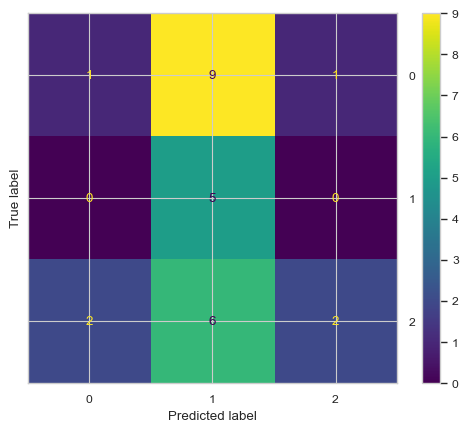

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = list_clf[0].predict(X_test)
cm = confusion_matrix(Y_test, predictions, labels=list_clf[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list_clf[0].classes_)
disp.plot()
plt.show()

In [81]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0, 
                    max_iter=10000,
                    early_stopping=True,
                    n_iter_no_change=1000)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 0.6366995073891626
TEST score : 0.5769230769230769
Next month :  [False] 0.5596370945820496

Target :  ur_stable
TRAIN score : 0.7610837438423645
TEST score : 0.7692307692307693
Next month :  [False] 0.5586839019165861

Target :  ur_higher
TRAIN score : 0.7179802955665024
TEST score : 0.5
Next month :  [False] 0.6898501237762087
